המטרה של פרויקט זה היא סיווג חולי סוכרת עפ"י פרמטרים שונים הקשורים לבריאות האדם

הספריות שבהן אשתמש במהלך הפרוייקט:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

העלאת הנתונים:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/diabetes_prediction_dataset.csv')


הצגת הנתונים על מנת לנרמל אותם:

In [ ]:
#נתונים על מאגר המידע ומחיקת שורות זהות
df.drop_duplicates(inplace=True)

print(df)
print(df.describe())
print(df.info())
print(df.head())


       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99994  Female  36.0             0              0         No Info  24.60   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140        

ניתן לראות שחלק מהנתונים הם לא מטיפוס שלם. אנרמל את הנתונים למספרים במקום מחרוזות ואמחק עמודות זהות אם יש

In [ ]:
#המרת מילים למספרים
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])
df['smoking_history'] = encoder.fit_transform(df['smoking_history'])
print(df)




       gender   age  hypertension  heart_disease  smoking_history    bmi  \
0           0  80.0             0              1                4  25.19   
1           0  54.0             0              0                0  27.32   
2           1  28.0             0              0                4  27.32   
3           0  36.0             0              0                1  23.45   
4           1  76.0             1              1                1  20.14   
...       ...   ...           ...            ...              ...    ...   
99994       0  36.0             0              0                0  24.60   
99996       0   2.0             0              0                0  17.37   
99997       1  66.0             0              0                3  27.83   
99998       0  24.0             0              0                4  35.42   
99999       0  57.0             0              0                1  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                 

עכשיו אבדוק את הקורלציות בין כל הנתונים במאגר

In [ ]:
#בודק את הקורלציות בין סוכרת לכל שאר הנתונים
df.corr()[['diabetes']].sort_values(by='diabetes', ascending=False)

,diabetes
diabetes,1.000000
blood_glucose_level,0.424336
HbA1c_level,0.406408
age,0.264927
bmi,0.214932
hypertension,0.195710
heart_disease,0.170711
smoking_history,0.088471
gender,0.037613


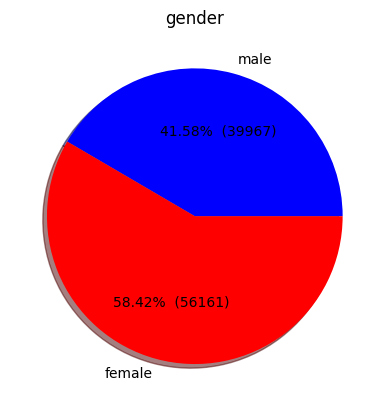

In [ ]:
male = df[(df['gender'] == 1)]
female = df[(df['gender'] == 0)]

counts1 = len(male)
counts2 = len(female)

colors = ['blue', 'red']
values = [counts1, counts2]
labels = ['male', 'female']


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, colors=colors, autopct=make_autopct(values),  shadow=True)
plt.title('gender')
plt.show()

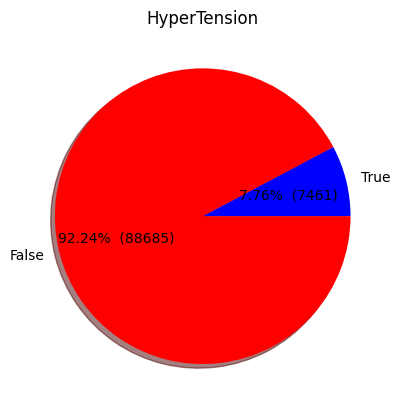

In [ ]:
hyp_true = df[(df['hypertension'] == 1)]
hyp_false = df[(df['hypertension'] == 0)]

counts1 = len(hyp_true)
counts2 = len(hyp_false)

colors = ['blue', 'red']
values = [counts1, counts2]
labels = ['True', 'False']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, labels=labels, colors=colors, autopct=make_autopct(values),  shadow=True)
plt.title('HyperTension')
plt.show()

ניתן לראות שיש קשר בין רמת הגלוקוז ורמת הגלוקוז הממוצעת בחודשים האחרונים לבין סוכרת אך מכיוון שמדדים אלו פעמים רבות הם תסמינים של סוכרת, אני אבדוק את הנתונים האחרונים, ובמיוחד אבדוק כיצד העישון משפיע

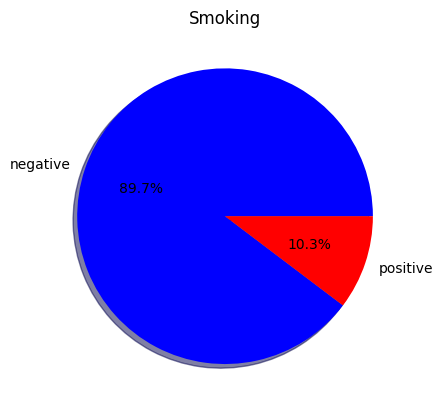

In [ ]:
smoking_negative = df[(df['smoking_history'] == 1)& (df['diabetes'] == 0)]
smoking_positive = df[(df['smoking_history'] == 1)& (df['diabetes'] == 1)]

#סוכם את כל הנתונים
counts1 = len(smoking_negative)
counts2 = len(smoking_positive)

#בחירת כותרות, צבעים וערכים
colors = ['blue', 'red']
values = [counts1, counts2]
labels = ['negative', 'positive']

#יוצר תרשים עוגה
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Smoking')
plt.show()

אבדוק אם יש קשר בין עישון ומחלות לב לסוכרת

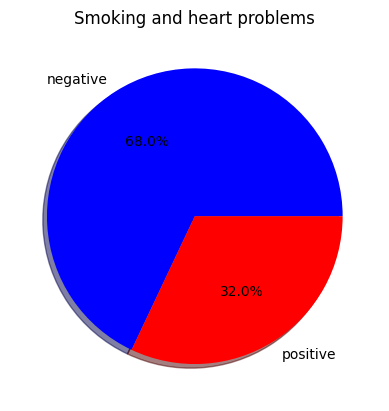

In [ ]:
#לוקח מהנתונים את השורות שבהן הנדבק בעל מחלת לב ומעשן קבוע ומחלק אותם לפי סוכרת(חיובי או שלילי)
smoking_and_heart_negative = df[(df['smoking_history'] == 1)
 & (df['heart_disease'] == 1) & (df['diabetes'] == 0)]
smoking_and_heart_positive = df[(df['smoking_history'] == 1)
 & (df['heart_disease'] == 1) & (df['diabetes'] == 1)]

 #סוכם את כל הנתונים
counts1 = len(smoking_and_heart_negative)
counts2 = len(smoking_and_heart_positive)

#בחירת כותרות, צבעים וערכים
colors = ['blue', 'red']
values = [counts1 ,counts2]
labels = ['negative', 'positive']



#יוצר תרשים עוגה
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Smoking and heart problems')
plt.show()





אבדוק אם יש קשר בין הגיל ועישון לסוכרת

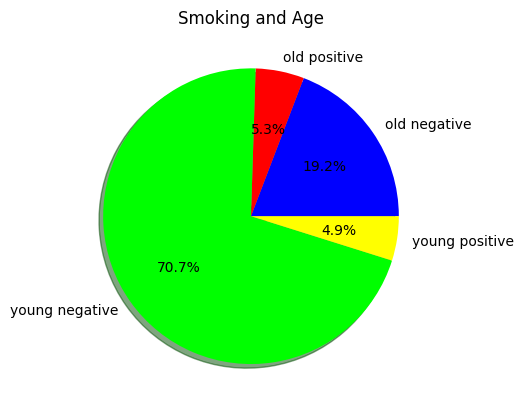

In [ ]:
#לוקח מהנתונים את השורות שבהן הנדבק בעל מחלת לב ולפי קבוצות גיל ומחלק אותם לפי סוכרת(חיובי או שלילי)
old_and_smoke_negative = df[(df['age'] > 55) & (df['smoking_history'] == 1)
 & (df['diabetes'] == 0)]
young_and_smoke_negative = df[(df['age'] < 55) & (df['smoking_history'] == 1)
 & (df['diabetes'] == 0)]
old_and_smoke_positive = df[(df['age'] > 55) & (df['smoking_history'] == 1)
 & (df['diabetes'] == 1)]
young_and_smoke_positive = df[(df['age'] < 55) & (df['smoking_history'] == 1)
 & (df['diabetes'] == 1)]

#סוכם את כל הנתונים
counts1 = len(old_and_smoke_negative)
counts2 = len(old_and_smoke_positive)
counts3 = len(young_and_smoke_negative)
counts4 = len(young_and_smoke_positive)

#בחירת כותרות, צבעים וערכים
colors = ['blue', 'red', 'lime', 'yellow']
values = [counts1 ,counts2, counts3, counts4]
labels = ['old negative', 'old positive', 'young negative', 'young positive']



#יוצר תרשים עוגה
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title("Smoking and Age")
plt.show()


In [ ]:
for column in df.columns:
  #לנרמל את המודל בין 0 ל1
    df[column] = df[column] / max(df[column])
print(df)

       gender     age  hypertension  heart_disease  smoking_history       bmi  \
0         0.0  1.0000           0.0            1.0              0.8  0.263246   
1         0.0  0.6750           0.0            0.0              0.0  0.285505   
2         0.5  0.3500           0.0            0.0              0.8  0.285505   
3         0.0  0.4500           0.0            0.0              0.2  0.245062   
4         0.5  0.9500           1.0            1.0              0.2  0.210471   
...       ...     ...           ...            ...              ...       ...   
99994     0.0  0.4500           0.0            0.0              0.0  0.257080   
99996     0.0  0.0250           0.0            0.0              0.0  0.181524   
99997     0.5  0.8250           0.0            0.0              0.6  0.290835   
99998     0.0  0.3000           0.0            0.0              0.8  0.370154   
99999     0.0  0.7125           0.0            0.0              0.2  0.234403   

       HbA1c_level  blood_g

In [ ]:
#מחלק את הנתונים למה שצריך לחזות לפרמטרים הנתונים
training_points = df.drop(['diabetes'], axis=1)
labels = df['diabetes']



אני אצור פונקציה שמטרתה היא להריץ את המודל מספר פעמים על מנת להשיג את רמת הדיוק הממוצעת של כל מודל

In [ ]:
#רשימות של מדדי הדיוק השונים
precision_scores = []
accuracy_scores = []
recall_scores = []

def ModelsAndData(model_name):
  #פונקציה המריצה את המודל מס' פעמים, ומדפיסה את הדיוק שלו במדדים שונים

    for _ in range(3):
      #מחלק לאימון ולחיזוי

      X_train, X_test, y_train, y_test = train_test_split(training_points,
               labels, test_size=0.2, random_state=42)

      #בוחר את סוג המודל ומאמן אותו
      if (model_name == 'knn'):
        model = KNeighborsClassifier(n_neighbors=17)
      if (model_name == 'log_reg'):
        model = LogisticRegression(C=0.01)
      if (model_name == 'svc'):
        model = svm.SVC(kernel='rbf')
      model.fit(X_train, y_train)

    # חוזה את הנתונים ומוסיפם לממצועי הדיוק
      predict = model.predict(X_test)

    #מחשב את מדדי הדיוק השונים
      precision = precision_score(y_test, predict)
      accuracy = accuracy_score(y_test, predict)
      recall = recall_score(y_test, predict)

#מוסיפם לממוצע
      precision_scores.append(precision)
      accuracy_scores.append(accuracy)
      recall_scores.append(recall)


    avg_precision = np.mean(precision_scores)
    avg_accuracy = np.mean(accuracy_scores)
    avg_recall = np.mean(recall_scores)

   #מדפיס את כל הנתונים
    print("model name: ", model_name ,
          "\nAverage Precision: ", avg_precision, "\nAverage Accuracy: ",
          avg_accuracy, "\nAverage Recall: ", avg_recall, "\n",
          confusion_matrix(y_test, predict), "\n",
          classification_report(y_test, predict))






In [ ]:
#מריץ את המודל knn
ModelsAndData('knn')

model name:  knn 
Average Precision:  0.9651282051282051 
Average Accuracy:  0.9576703068122724 
Average Recall:  0.546775130737943 
 [[17475    34]
 [  780   941]] 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     17509
         1.0       0.97      0.55      0.70      1721

    accuracy                           0.96     19230
   macro avg       0.96      0.77      0.84     19230
weighted avg       0.96      0.96      0.95     19230



In [ ]:
#מריץ את המודל logistic regression
ModelsAndData('log_reg')

model name:  log_reg 
Average Precision:  0.958499931441108 
Average Accuracy:  0.9472698907956317 
Average Recall:  0.4285299244625218 
 [[17482    27]
 [ 1187   534]] 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     17509
         1.0       0.95      0.31      0.47      1721

    accuracy                           0.94     19230
   macro avg       0.94      0.65      0.72     19230
weighted avg       0.94      0.94      0.92     19230



In [ ]:
# מריץ את המודל svc
ModelsAndData('svc')

model name:  svc 
Average Precision:  0.9611010444823772 
Average Accuracy:  0.9513260530421217 
Average Recall:  0.47453031183420497 
 [[17475    34]
 [  746   975]] 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     17509
         1.0       0.97      0.57      0.71      1721

    accuracy                           0.96     19230
   macro avg       0.96      0.78      0.85     19230
weighted avg       0.96      0.96      0.95     19230

